## DISCLAIMER

This is implementation from pyTorch tutorials - https://pytorch.org/tutorials/intermediate/reinforcement_ppo.html

They use some weird convention of naming value network as critic network and policy network as actor network. This is not only the matter of this notebook or their tutorial but also the parameters withing torchrl library

## Importing Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
from torch import multiprocessing


from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,
                          TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, OneHotCategorical, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

## Hyperparameters

In [2]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)

num_cells = 256  # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0

### Data Collection

In [3]:
# buffer_size = 10000
# batch_size = 1000 # Number of frames per batch
# For a complete training, bring the number of frames up to 1M
total_frames = 100_000 # total size of frames to train on
max_steps = 500

### PPO parameters

In [4]:
# batch_size = 10240 # Number of frames per batch
# sub_batch_size = 1024  # cardinality of the sub-samples gathered from the current data in the inner loop

# batch_size = 5120
batch_size = 10240
sub_batch_size = 1024

num_epochs = 3  # optimization steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95

# Calculating PPO loss
critic_coef = 0.5
entropy_eps = 0
entropy_eps = 0.005

# entropy_eps = LinearDecay(start=entropy_eps, end=0.0005, total_steps=total_frames)

## Environment

In [5]:
import gym
import numpy as np

from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.envs.unity_gym_env import UnityToGymWrapper
from torchrl.envs import GymWrapper, TransformedEnv, Compose, ObservationNorm, DoubleToFloat, StepCounter

class UnityGymTorchWrapper(gym.Env):
    """
    Custom wrapper for UnityToGymWrapper to make it compatible with TorchRL's GymWrapper.
    """

    def __init__(self, unity_gym_env):
        super().__init__()
        self.unity_gym_env = unity_gym_env
        self.observation_space = unity_gym_env.observation_space
        self.action_space = unity_gym_env.action_space
        
        # print("init")

    def reset(self):
        observation = self.unity_gym_env.reset()
        if isinstance(observation, list):  
            observation = np.concatenate(observation, axis=-1)
        # print("observation", observation)
        return {"observation": observation}, {}  # TorchRL expects a dictionary

    def step(self, action):
        # print("step")
      
        observation, reward, done, info = self.unity_gym_env.step(action)
        if isinstance(observation, list):  
            observation = np.concatenate(observation, axis=-1)
        
        # Split `done` into `terminated` and `truncated`
        terminated = done  # Assuming `done` corresponds to a terminal state
        truncated = False  # Unity environments don't have truncation by default
        
        # print(terminated)
        # print(truncated)
        
        return {"observation": observation}, reward, terminated, truncated, info

    def render(self, mode="human"):
        # print("render")
        return self.unity_gym_env.render(mode=mode)

    def close(self):
        # print("close")
        self.unity_gym_env.close()


In [6]:
channel = EngineConfigurationChannel()
env_path = "C:/Users/Pawel/Documents/Unity_Project/warehouse-bot-training/environment_builds/test_env/Warehouse_Bot.exe"

unity_env = UnityEnvironment(
  file_name=env_path,
  side_channels=[channel],
  # additional_args=["-batchmode", "-nographics"]
)
channel.set_configuration_parameters(time_scale=3)

# Convert Unity environment to Gym and wrap it for TorchRL
unity_gym_env = UnityToGymWrapper(unity_env, allow_multiple_obs=True)
custom_env = UnityGymTorchWrapper(unity_gym_env)

# Wrap the custom Gym environment into TorchRL-compatible environment
base_env = GymWrapper(custom_env)

c:\Users\Pawel\anaconda3\envs\mlagents_env\lib\site-packages\mlagents_envs\environment.py:94: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  unity_communicator_version = StrictVersion(unity_com_ver)


### Environment Normalization

In [7]:
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(),
        StepCounter(),
    ),
)

In [8]:
env.transform[0].init_stats(num_iter=500, reduce_dim=0, cat_dim=0)

## Environment Testing

In [9]:
print("normalization constant shape:", env.transform[0].loc.shape)

normalization constant shape: torch.Size([1, 500])


In [10]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

observation_spec: CompositeSpec(
    observation: UnboundedContinuousTensorSpec(
        shape=torch.Size([1, 500]),
        space=None,
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    step_count: BoundedTensorSpec(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True),
            high=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True)),
        device=cpu,
        dtype=torch.int64,
        domain=continuous),
    device=None,
    shape=torch.Size([]))
reward_spec: UnboundedContinuousTensorSpec(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True),
        high=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True)),
    device=cpu,
    dtype=torch.float32,
    domain=continuous)
input_spec: CompositeSpec(
    fu

In [11]:
check_env_specs(env)

2025-02-13 10:42:57,011 [torchrl][INFO] check_env_specs succeeded!


In [12]:
rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([3, 1, 500]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.int64, is_shared=False),
                terminated: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([3]),
            de

## Policy Network

In [13]:
class Policy_Network(nn.Module):
    def __init__(self, num_cells) -> None:
        super().__init__()
        self.main = nn.Sequential(
            nn.LazyLinear(num_cells, device=device),
            nn.ReLU(),
            nn.LazyLinear(num_cells, device=device),
            nn.ReLU(),
            nn.LazyLinear(env.action_spec.shape[-1], device=device),
            # NormalParamExtractor(),
        )
        
    def forward(self, inputs):        
        result = self.main(inputs)
        return result

In [14]:
policy_net = Policy_Network(num_cells).to(device)

policy_module = TensorDictModule(
    policy_net, in_keys=["observation"], out_keys=["logits"] #out_keys=["loc", "scale"]
)

policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["logits"],
    distribution_class=OneHotCategorical,
    distribution_kwargs={},
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
).to(device)

## Value Network

In [15]:
class Value_Network(nn.Module):
    def __init__(self, num_cells) -> None:
        super().__init__()
        self.main = nn.Sequential(
            nn.LazyLinear(num_cells, device=device),
            nn.ReLU(),
            nn.LazyLinear(num_cells, device=device),
            nn.ReLU(),
            nn.LazyLinear(1, device=device),
            nn.Flatten()
        )
        
    def forward(self, inputs):
        # print(f'inputs: {inputs.shape}')
        
        result = self.main(inputs)
        # print(f'result: {result.shape}')
        return result

In [16]:
value_net = Value_Network(128).to(device)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
).to(device)

## Tesitng Policy and Value Modules

In [17]:
print("Running policy:", policy_module(env.reset().to(device)))
print("Running value:", value_module(env.reset().to(device)))


Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1, 3]), device=cuda:0, dtype=torch.int64, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        logits: Tensor(shape=torch.Size([1, 3]), device=cuda:0, dtype=torch.float32, is_shared=True),
        observation: Tensor(shape=torch.Size([1, 500]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, is_shared=True),
        terminated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        truncated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_shared=True)
Running value: TensorDict(
    fields={
        done: Tensor(shape=torch.Si

## Data Collector

In [ ]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=batch_size,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
    reset_when_done=True, # ??? VERIFY
    # reset_at_each_iter=True, # ??? VERIFY - Should be false (default)
)

## Replay Buffer

In [19]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=batch_size),
    sampler=SamplerWithoutReplacement(),
)

## Loss Function

In [20]:
from torch.optim.lr_scheduler import LambdaLR

# GAE - Generalized Advantage Estimation
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    
    critic_coef=critic_coef,
)

optimizer = torch.optim.Adam(loss_module.parameters(), lr)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optim, total_frames // batch_size, 0.0
# )

lr_scheduler = LambdaLR(optimizer, lambda epoch: 1 - batch_size / total_frames)

## Trainign Loop

In [21]:
print("Policy Device:", next(policy_module.parameters()).device)
print("Environment Device:", env.device)

Policy Device: cuda:0
Environment Device: cuda:0


In [ ]:
from torchrl.envs.utils import LazyStackedTensorDict
import pandas as pd

logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.

    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.

        # Compute advantage
        advantage_module(tensordict_data)
        
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(batch_size // sub_batch_size):
          
            subdata = replay_buffer.sample(sub_batch_size)
            
            loss_dict = loss_module(subdata.to(device))
            # print('loss_vals ', loss_vals, loss_vals["loss_objective"], loss_vals["loss_critic"], loss_vals["loss_entropy"])
            
            if 'loss_entropy' in loss_dict:
                loss_value = (
                    loss_dict["loss_objective"]
                    + loss_dict["loss_critic"]
                    + loss_dict["loss_entropy"]
                )
            else:
                loss_value = (
                    loss_dict["loss_objective"]
                    + loss_dict["loss_critic"]
                )
            
            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            
            optimizer.step()
            optimizer.zero_grad()



    # print(i)
    if i % 1 == 0:
        # Loggs ---
        
        # Convert to CPU & NumPy for easier aggregation
        rewards = tensordict_data["next", "reward"].cpu().numpy().flatten()
        done_flags = tensordict_data["done"].cpu().numpy().flatten()
        traj_ids = tensordict_data["collector", "traj_ids"].cpu().numpy().flatten()

        # Create a DataFrame for easier aggregation
        df = pd.DataFrame({"traj_id": traj_ids, "reward": rewards, "done": done_flags})

        # Sum rewards for each unique trajectory ID
        episode_rewards = df.groupby("traj_id")["reward"].sum().to_numpy()
        
        # ---
    
        logs["reward"].append(tensordict_data["next", "reward"].mean().item())
        logs["reward_episodes"].append(episode_rewards.mean())
        
        # print(episode_rewards, episode_rewards.mean(), logs["reward_episodes"], logs["reward_episodes"][0], logs['reward_episodes'][-1])
        reward_str = (
            f"avg reward={logs['reward'][-1]} (init={logs['reward'][0]}) episode reward={logs['reward_episodes'][-1]} (init={logs['reward_episodes'][0]})"
        )
        
        logs["step_count"].append(tensordict_data["step_count"].max().item())
        stepcount_str = f"step count (max): {logs['step_count'][-1]}"
        
        logs["lr"].append(optimizer.param_groups[0]["lr"])
        lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
        
        # ---

    # print(", ".join([reward_str, stepcount_str, lr_str]))
    pbar.set_description(", ".join([reward_str, stepcount_str, lr_str]))
    pbar.update(tensordict_data.numel())
    
    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    lr_scheduler.step()

avg reward=-0.9909765124320984 (init=-0.7565624713897705) episode reward=-117.99534606933594 (init=-124.95482635498047), step count (max): 499, lr policy:  0.0003: : 102400it [11:34, 147.55it/s]                         

In [23]:
env.action_spec.space

DiscreteBox(n=3)

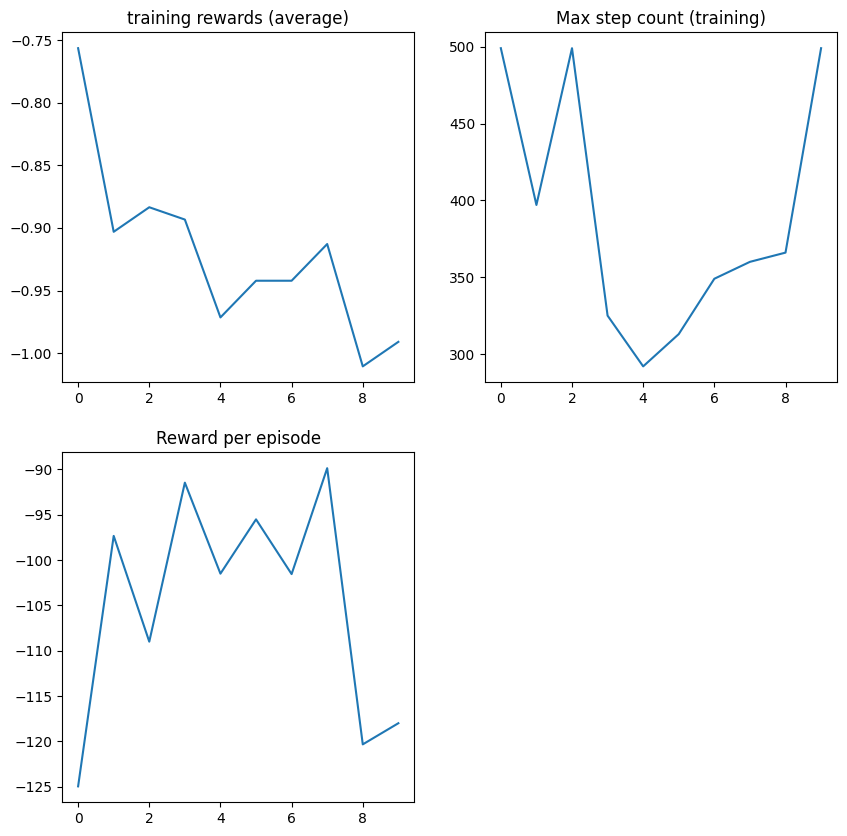

avg reward=-0.9909765124320984 (init=-0.7565624713897705) episode reward=-117.99534606933594 (init=-124.95482635498047), step count (max): 499, lr policy:  0.0003: : 102400it [11:50, 147.55it/s]

In [24]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
# plt.subplot(2, 2, 3)
# plt.plot(logs["eval reward (sum)"])
# plt.title("Return (test)")
# plt.subplot(2, 2, 4)
# plt.plot(logs["eval step_count"])
# plt.title("Max step count (test)")
# plt.show()

plt.subplot(2, 2, 3)
plt.plot(logs["reward_episodes"])
plt.title("Reward per episode")
# plt.subplot(2, 2, 4)
# plt.plot(logs["eval step_count"])
# plt.title("Max step count (test)")
plt.show()